In [1]:
import os
from PIL import Image, ImageFont
from IPython.display import display
from tqdm import tqdm
import torch
from torchvision.transforms.functional import to_tensor, to_pil_image

from utils.initialize_font_data import fox_text
from utils.init_model import model, preprocess, load_model, device
from utils.cross_lingual_font_retrieval import exclusive_cjk_font_paths
from dataset.dataset import MyDataset
from utils.transform_image import draw_text_with_new_lines
from utils.clip_adapter import CLIPAdapter

cjk_font_dir_path = '../all-fonts'
all_font_paths = [os.path.join(cjk_font_dir_path, font_name) for font_name in os.listdir(cjk_font_dir_path)]
inclusive_cjk_font_paths = [font_path for font_path in all_font_paths if os.path.basename(font_path) not in exclusive_cjk_font_paths]
print('Number of inclusive_cjk_font_paths', len(inclusive_cjk_font_paths))

character_size = 150


exclusive_attributes:  ['capitals', 'cursive', 'display', 'italic', 'monospace', 'serif']
Number of inclusive_cjk_font_paths 287


In [2]:
roman_text = fox_text
cjk_text = '夏底青\n森市草'
cjk_text = '夏林\n火山'
# cjk_text = '夏林夏林\n火山火山'
# cjk_text = '夏林夏林\n火山火山\n夏林夏林\n火山火山'
# cjk_text = '夏林海川\n火山水鳥\n魚肉美味\n酒池日本'
# cjk_text = '海川\n水鳥'
# cjk_text = '夏林海\n火山水\n魚肉美'
# cjk_text = '夏林夏\n火山火\n夏林夏'
# cjk_text = '夏林夏林夏林\n火山火山火山\n夏林夏林夏林\n火山火山火山\n夏林夏林夏林\n火山火山火山'

In [5]:
checkpoint_path = 'model_checkpoints/2_9101191011_batch64_aug250_use_negative_use_negative_loss0.0_lr2e-05-0.1_image_file_dir.pt'
checkpoint_path = 'model_checkpoints/1_9101191011_batch64_aug250_use_negative_loss0.0_lr2e-05-0.1_image_file_dir.pt'
# checkpoint_path = 'model_checkpoints/2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss0.0001_lr2e-05-0.1_image_file_dir.pt'
checkpoint_path = 'model_checkpoints/2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss0.0_lr2e-05-0.1_image_file_dir.pt'
# checkpoint_path = 'model_checkpoints/ViT-B_32_9101191011_batch64_aug250_use_negative_lr2e-05-0.1_image_file_dir.pt'
# checkpoint_path = None
model = load_model(model, checkpoint_path)

clip_adapter_checkpoint_path = None
# clip_adapter_checkpoint_path = 'model_checkpoints/ViT-B_32_dual_adapter_reduction2_ratio1.0_layer_num2__batch64_aug250_lower_bound_of_scale0.35_use_negative_lr0.0002-0.1_image_file_dir.pt'
# clip_adapter_checkpoint_path = 'model_checkpoints/ViT-B_32_dual_adapter_reduction2_ratio1.0_layer_num2_pretrained_fclip__batch64_aug250_lower_bound_of_scale0.35_use_negative_lr0.0002-0.1_image_file_dir.pt'
clip_adapter = None
if clip_adapter_checkpoint_path is not None:
    clip_adapter = CLIPAdapter(model, reduction=2, ratio=1.0, layer_num=2)
    clip_adapter.load_state_dict(torch.load(clip_adapter_checkpoint_path)['model_state_dict'])
    clip_adapter = clip_adapter.to(device)

In [6]:
cjk_line_count = cjk_text.count('\n') + 1
cjk_img_width = len(max(cjk_text.split('\n'), key=len)) * character_size
cjk_img_height = character_size * (cjk_line_count + 2)

roman_line_count = roman_text.count('\n') + 1
roman_img_width = len(max(roman_text.split('\n'), key=len)) * character_size
roman_img_height = character_size * (roman_line_count + 2)

embedded_cjk_image_tensors = []
embedded_roman_image_tensors = []
count = 0
for font_path in tqdm(inclusive_cjk_font_paths):
    font = ImageFont.truetype(font_path, character_size)
    cjk_image = draw_text_with_new_lines(cjk_text, font, img_width=cjk_img_width, img_height=cjk_img_height)
    cjk_preprocessed_image = preprocess(cjk_image).to(device)
    embedded_cjk_image_tensor = model.encode_image(cjk_preprocessed_image.unsqueeze(0))
    if clip_adapter is not None:
        embedded_cjk_image_tensor = clip_adapter.encode_image(embedded_cjk_image_tensor)
    embedded_cjk_image_tensor = embedded_cjk_image_tensor.cpu()
    embedded_cjk_image_tensor = embedded_cjk_image_tensor / embedded_cjk_image_tensor.norm(dim=-1, keepdim=True)
    embedded_cjk_image_tensors.append(embedded_cjk_image_tensor)
    # embedded_cjk_image_tensors.append(model.encode_image(cjk_preprocessed_image.unsqueeze(0)).to('cpu'))


    roman_image = draw_text_with_new_lines(roman_text, font, img_width=roman_img_width, img_height=roman_img_height)
    roman_preprocessed_image = preprocess(roman_image).to(device)
    embedded_roman_image_tensor = model.encode_image(roman_preprocessed_image.unsqueeze(0))
    if clip_adapter is not None:
        embedded_roman_image_tensor = clip_adapter.encode_image(embedded_roman_image_tensor)
    embedded_roman_image_tensor = embedded_roman_image_tensor.cpu()
    embedded_roman_image_tensor = embedded_roman_image_tensor / embedded_roman_image_tensor.norm(dim=-1, keepdim=True)
    embedded_roman_image_tensors.append(embedded_roman_image_tensor)
    # embedded_roman_image_tensors.append(model.encode_image(roman_preprocessed_image.unsqueeze(0)).to('cpu'))

100%|██████████| 287/287 [00:07<00:00, 39.83it/s]


In [51]:
cos_sim_matrix = torch.cat(embedded_roman_image_tensors).to(device) @ torch.cat(embedded_cjk_image_tensors).to(device).T
cos_sim_matrix = cos_sim_matrix.cpu()

In [54]:
roman_to_cjk_count = 0
cjk_to_roman_count = 0
roman_to_cjk_correct_count = 0
cjk_to_roman_correct_count = 0
for i in tqdm(range(0, len(inclusive_cjk_font_paths)-1)):
  for j in range(i+1, len(inclusive_cjk_font_paths)):
    # compare cosine similarity (Roman to CJK)
    similarity_1 = cos_sim_matrix[i][i]
    similarity_2 = cos_sim_matrix[i][j]
    roman_to_cjk_count += 1
    if similarity_1 > similarity_2:
      roman_to_cjk_correct_count += 1

    similarity_1 = cos_sim_matrix[j][i]
    similarity_2 = cos_sim_matrix[j][j]
    roman_to_cjk_count += 1
    if similarity_2 > similarity_1:
      roman_to_cjk_correct_count += 1

    # compare cosine similarity (CJK to Roman)
    similarity_1 = cos_sim_matrix[i][i]
    similarity_2 = cos_sim_matrix[j][i]
    cjk_to_roman_count += 1
    if similarity_1 > similarity_2:
      cjk_to_roman_correct_count += 1
    
    similarity_1 = cos_sim_matrix[i][j]
    similarity_2 = cos_sim_matrix[j][j]
    cjk_to_roman_count += 1
    if similarity_2 > similarity_1:
      cjk_to_roman_correct_count += 1

print('Roman to CJK Accuracy', roman_to_cjk_correct_count/roman_to_cjk_count)    
print('CJK to Roman Accuracy', cjk_to_roman_correct_count/cjk_to_roman_count)


100%|██████████| 286/286 [00:00<00:00, 740.49it/s]

Roman to CJK Accuracy 0.6155064447747375
CJK to Roman Accuracy 0.5749981725591482


In [53]:
# top1 and top5 accuracy
roman_to_cjk_top1_count = 0
roman_to_cjk_top5_count = 0
cjk_to_roman_top1_count = 0
cjk_to_roman_top5_count = 0

for i in tqdm(range(0, len(inclusive_cjk_font_paths))):
  # roman to cjk
  similarity_list = cos_sim_matrix[i].detach().numpy()
  similarity_list = list(enumerate(similarity_list))
  similarity_list.sort(key=lambda x: x[1], reverse=True)
  top1 = similarity_list[0][0]
  top5 = [similarity_list[j][0] for j in range(5)]
  if i == top1:
    roman_to_cjk_top1_count += 1
  if i in top5:
    roman_to_cjk_top5_count += 1
  
  # cjk to roman
  similarity_list = cos_sim_matrix[:, i].detach().numpy()
  similarity_list = list(enumerate(similarity_list))
  similarity_list.sort(key=lambda x: x[1], reverse=True)
  top1 = similarity_list[0][0]
  top5 = [similarity_list[j][0] for j in range(5)]
  if i == top1:
    cjk_to_roman_top1_count += 1
  if i in top5:
    cjk_to_roman_top5_count += 1

print('Roman to CJK Top1 Accuracy', roman_to_cjk_top1_count/len(inclusive_cjk_font_paths))
print('Roman to CJK Top5 Accuracy', roman_to_cjk_top5_count/len(inclusive_cjk_font_paths))
print('CJK to Roman Top1 Accuracy', cjk_to_roman_top1_count/len(inclusive_cjk_font_paths))
print('CJK to Roman Top5 Accuracy', cjk_to_roman_top5_count/len(inclusive_cjk_font_paths))

100%|██████████| 287/287 [00:00<00:00, 10742.25it/s]

Roman to CJK Top1 Accuracy 0.006968641114982578
Roman to CJK Top5 Accuracy 0.041811846689895474
CJK to Roman Top1 Accuracy 0.006968641114982578
CJK to Roman Top5 Accuracy 0.05574912891986063


In [72]:
checkpoint_paths = [
  '2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss0.0001_lr2e-05-0.1_image_file_dir.pt',
  '2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss0.001_lr2e-05-0.1_image_file_dir.pt',
  '2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss0.01_lr2e-05-0.1_image_file_dir.pt',
  '2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss0.0_lr2e-05-0.1_image_file_dir.pt',
  '2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss0.1_lr2e-05-0.1_image_file_dir.pt',
  '2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss0_lr2e-05-0.1_image_file_dir.pt',
  '2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss1e-05_lr2e-05-0.1_image_file_dir.pt',
  '2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss1e-06_lr2e-05-0.1_image_file_dir.pt',
  '2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss1e-07_lr2e-05-0.1_image_file_dir.pt',
  '2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss1e-08_lr2e-05-0.1_image_file_dir.pt',
]

cjk_texts = [
  # '夏底青\n森市草',
  # '永',
  # '夏',
  # '風林\n火山',
  '夏林\n火山',
  '林夏\n火山',
  '火林\n夏山',
  '山林\n火夏',
  # '夏底青\n森市草\n夏底青\n森市草',
]

In [73]:
roman_to_cjk_failure_cases = None
cjk_to_roman_failure_cases = None
roman_to_cjk_success_cases = None
cjk_to_roman_success_cases = None

# for checkpoint_path in tqdm(checkpoint_paths):
for cjk_text in tqdm(cjk_texts):
  tmp_roman_to_cjk_failure_cases = set()
  tmp_cjk_to_roman_failure_cases = set()
  tmp_roman_to_cjk_success_cases = set()
  tmp_cjk_to_roman_success_cases = set()

  # checkpoint_path = os.path.join('model_checkpoints', checkpoint_path)
  # print(checkpoint_path)
  # model = load_model(model, checkpoint_path)
  print('cjk_text', cjk_text)
  cjk_line_count = cjk_text.count('\n') + 1
  cjk_img_width = len(max(cjk_text.split('\n'), key=len)) * character_size
  cjk_img_height = character_size * (cjk_line_count + 2)

  roman_line_count = roman_text.count('\n') + 1
  roman_img_width = len(max(roman_text.split('\n'), key=len)) * character_size
  roman_img_height = character_size * (roman_line_count + 2)

  embedded_cjk_image_tensors = []
  embedded_roman_image_tensors = []
  count = 0
  for font_path in tqdm(inclusive_cjk_font_paths):
      font = ImageFont.truetype(font_path, character_size)
      cjk_image = draw_text_with_new_lines(cjk_text, font, img_width=cjk_img_width, img_height=cjk_img_height)
      cjk_preprocessed_image = preprocess(cjk_image).to(device)
      embedded_cjk_image_tensors.append(model.encode_image(cjk_preprocessed_image.unsqueeze(0)).to('cpu'))


      roman_image = draw_text_with_new_lines(roman_text, font, img_width=roman_img_width, img_height=roman_img_height)
      roman_preprocessed_image = preprocess(roman_image).to(device)
      embedded_roman_image_tensors.append(model.encode_image(roman_preprocessed_image.unsqueeze(0)).to('cpu'))
  
  roman_to_cjk_count = 0
  cjk_to_roman_count = 0
  roman_to_cjk_correct_count = 0
  cjk_to_roman_correct_count = 0
  for i in tqdm(range(0, len(inclusive_cjk_font_paths)-1)):
    for j in range(i+1, len(inclusive_cjk_font_paths)):
      roman_image_tensor_1 = embedded_roman_image_tensors[i].to(device)
      roman_image_tensor_2 = embedded_roman_image_tensors[j].to(device)
      cjk_image_tensor_1 = embedded_cjk_image_tensors[i].to(device)
      cjk_image_tensor_2 = embedded_cjk_image_tensors[j].to(device)

      # compare cosine similarity (Roman to CJK)
      similarity_1 = torch.cosine_similarity(roman_image_tensor_1, cjk_image_tensor_1, dim=1)
      similarity_2 = torch.cosine_similarity(roman_image_tensor_1, cjk_image_tensor_2, dim=1)
      roman_to_cjk_count += 1
      if similarity_1 > similarity_2:
        roman_to_cjk_correct_count += 1
        tmp_roman_to_cjk_success_cases.add((i, j))
      else:
        tmp_roman_to_cjk_failure_cases.add((i, j))

      similarity_1 = torch.cosine_similarity(roman_image_tensor_2, cjk_image_tensor_1, dim=1)
      similarity_2 = torch.cosine_similarity(roman_image_tensor_2, cjk_image_tensor_2, dim=1)
      roman_to_cjk_count += 1
      if similarity_2 > similarity_1:
        roman_to_cjk_correct_count += 1
        tmp_roman_to_cjk_success_cases.add((j, i))
      else:
        tmp_roman_to_cjk_failure_cases.add((j, i))

      # compare cosine similarity (CJK to Roman)
      similarity_1 = torch.cosine_similarity(cjk_image_tensor_1, roman_image_tensor_1, dim=1)
      similarity_2 = torch.cosine_similarity(cjk_image_tensor_1, roman_image_tensor_2, dim=1)
      cjk_to_roman_count += 1
      if similarity_1 > similarity_2:
        cjk_to_roman_correct_count += 1
        tmp_cjk_to_roman_success_cases.add((i, j))
      else:
        tmp_cjk_to_roman_failure_cases.add((i, j))
      
      similarity_1 = torch.cosine_similarity(cjk_image_tensor_2, roman_image_tensor_1, dim=1)
      similarity_2 = torch.cosine_similarity(cjk_image_tensor_2, roman_image_tensor_2, dim=1)
      cjk_to_roman_count += 1
      if similarity_2 > similarity_1:
        cjk_to_roman_correct_count += 1
        tmp_cjk_to_roman_success_cases.add((j, i))
      else:
        tmp_cjk_to_roman_failure_cases.add((j, i))
  
  if roman_to_cjk_failure_cases is not None:
    roman_to_cjk_failure_cases = roman_to_cjk_failure_cases.intersection(tmp_roman_to_cjk_failure_cases)
    cjk_to_roman_failure_cases = cjk_to_roman_failure_cases.intersection(tmp_cjk_to_roman_failure_cases)
    roman_to_cjk_success_cases = roman_to_cjk_success_cases.intersection(tmp_roman_to_cjk_success_cases)
    cjk_to_roman_success_cases = cjk_to_roman_success_cases.intersection(tmp_cjk_to_roman_success_cases)
  else:
    roman_to_cjk_failure_cases = tmp_roman_to_cjk_failure_cases
    cjk_to_roman_failure_cases = tmp_cjk_to_roman_failure_cases
    roman_to_cjk_success_cases = tmp_roman_to_cjk_success_cases
    cjk_to_roman_success_cases = tmp_cjk_to_roman_success_cases
    

  print('Roman to CJK Accuracy', roman_to_cjk_correct_count/roman_to_cjk_count)    
  print('CJK to Roman Accuracy', cjk_to_roman_correct_count/cjk_to_roman_count)

  0%|          | 0/4 [00:00<?, ?it/s]

cjk_text 夏林
火山


 25%|██▌       | 1/4 [00:17<00:52, 17.44s/it]

Roman to CJK Accuracy 0.7175558719182881
CJK to Roman Accuracy 0.6511309967685807
cjk_text 林夏
火山


 50%|█████     | 2/4 [00:35<00:35, 17.55s/it]

Roman to CJK Accuracy 0.7038053917248548
CJK to Roman Accuracy 0.6316294940456014
cjk_text 火林
夏山


 75%|███████▌  | 3/4 [00:52<00:17, 17.50s/it]

Roman to CJK Accuracy 0.7111721239238018
CJK to Roman Accuracy 0.6435043951822476
cjk_text 山林
火夏


100%|██████████| 4/4 [01:09<00:00, 17.48s/it]

Roman to CJK Accuracy 0.7014778659073961
CJK to Roman Accuracy 0.6279122319390775


(110, 190)


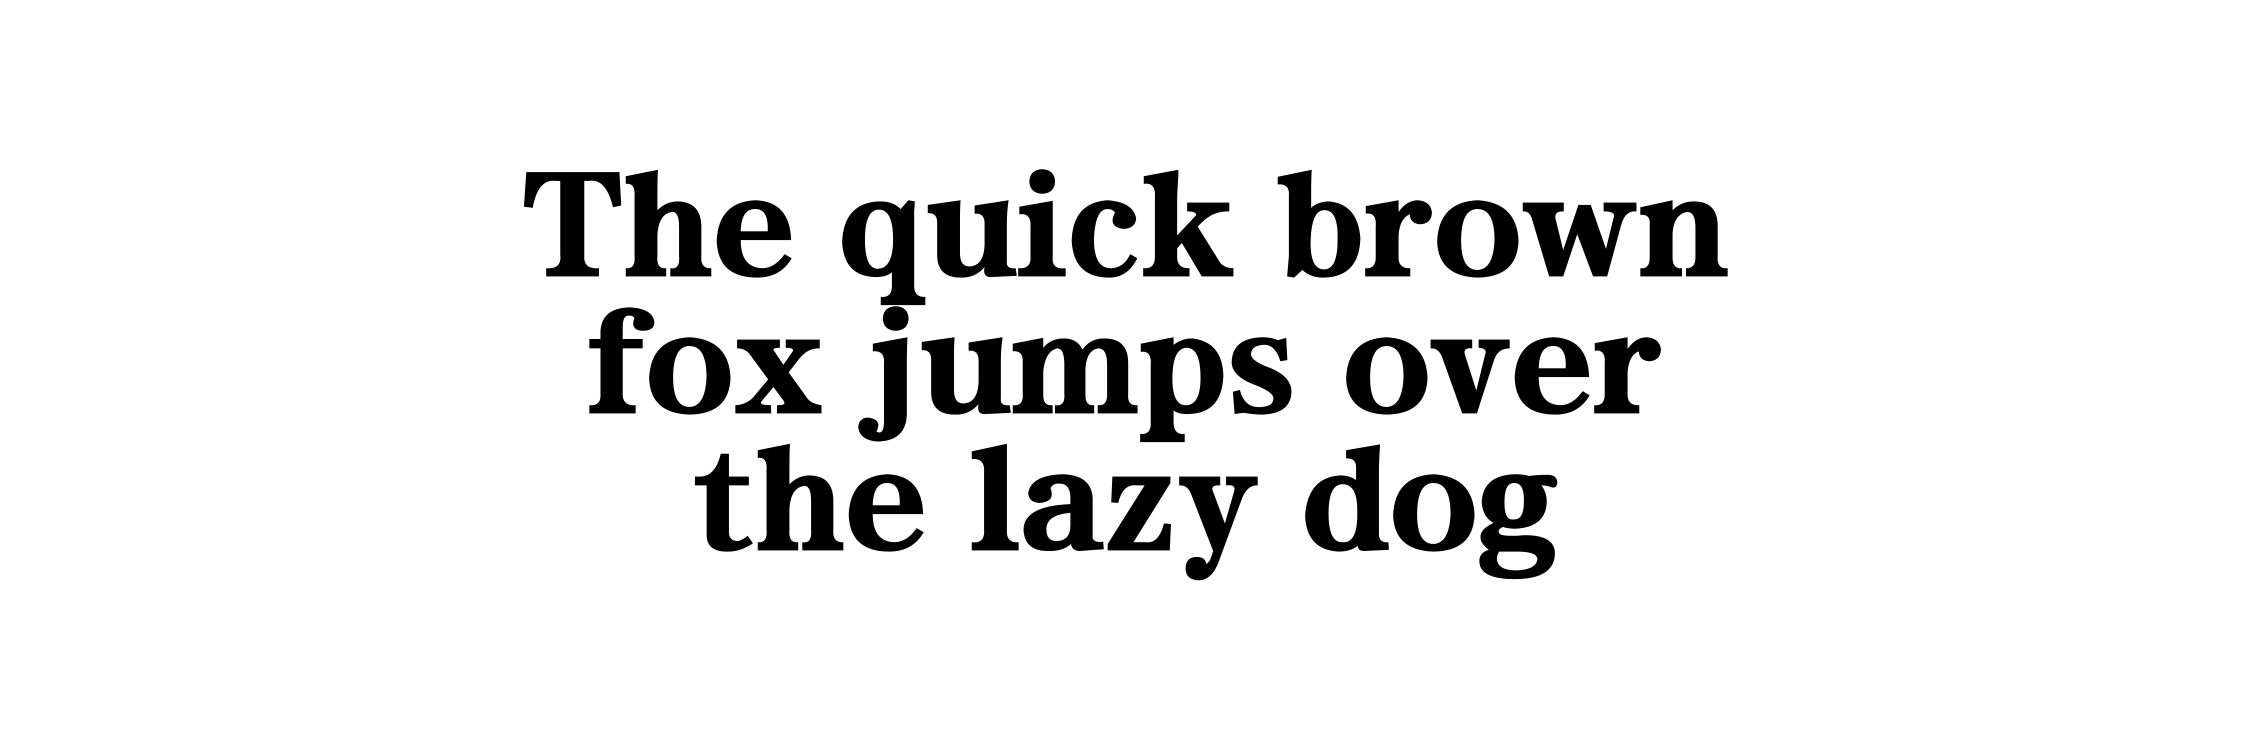

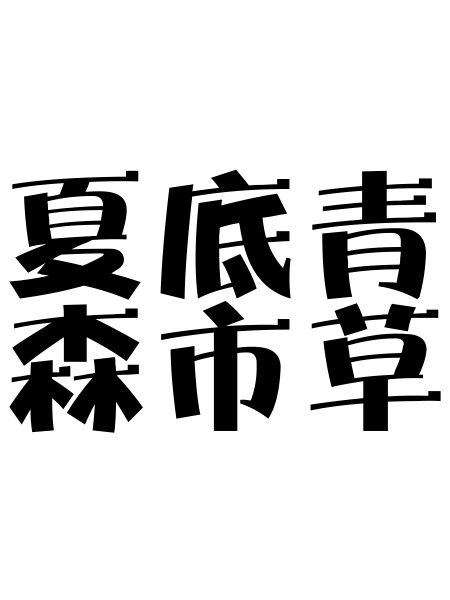

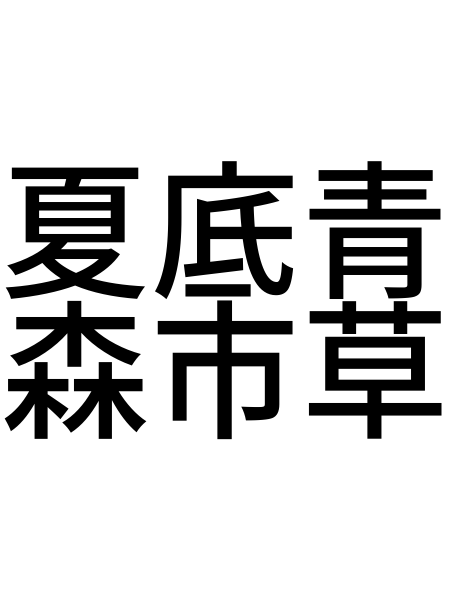

---------------------
(171, 86)


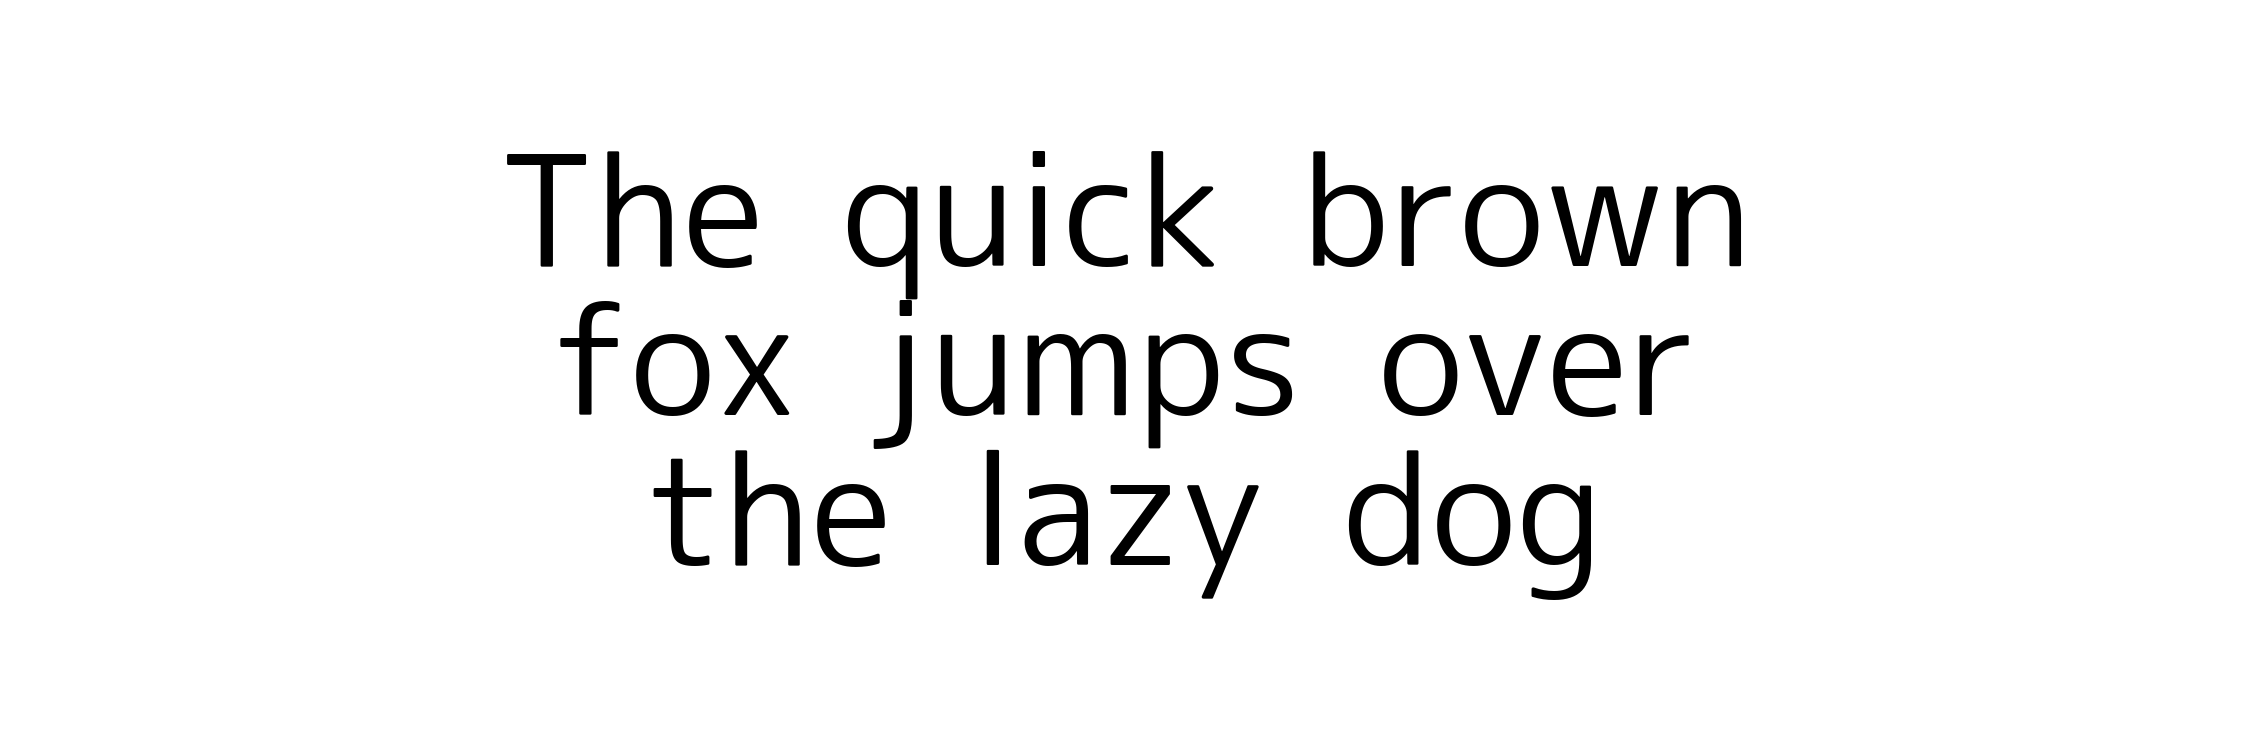

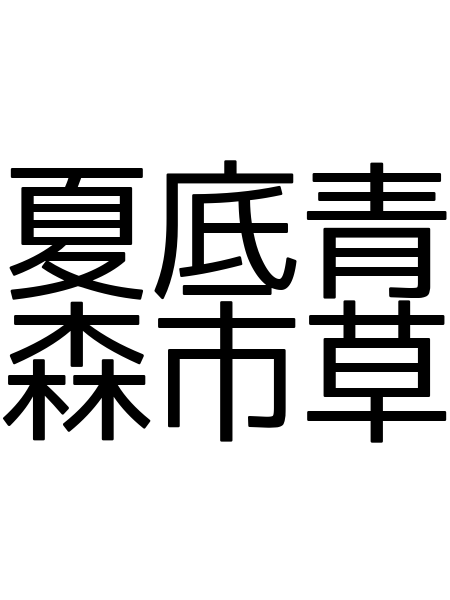

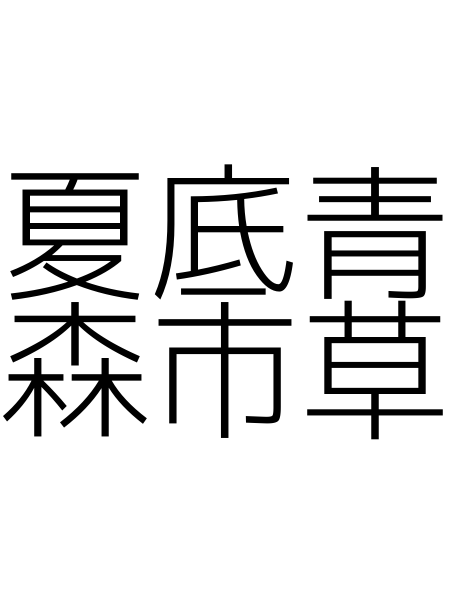

---------------------


In [58]:
count = 0
for e in roman_to_cjk_failure_cases:
  print(e)
  font_path_1 = inclusive_cjk_font_paths[e[0]]
  font_path_2 = inclusive_cjk_font_paths[e[1]]
  font_1 = ImageFont.truetype(font_path_1, character_size)
  font_2 = ImageFont.truetype(font_path_2, character_size)
  roman_image = draw_text_with_new_lines(roman_text, font_1, img_width=roman_img_width, img_height=roman_img_height)
  cjk_image_1 = draw_text_with_new_lines(cjk_text, font_1, img_width=cjk_img_width, img_height=cjk_img_height)
  cjk_image_2 = draw_text_with_new_lines(cjk_text, font_2, img_width=cjk_img_width, img_height=cjk_img_height)
  display(roman_image)
  display(cjk_image_1)
  display(cjk_image_2)
  print('---------------------')
  count += 1
  if count > 1:
    break